# **Predicting Tripadvisor hotel reviews using CNN**

สร้างโมลเดลสำหรับการทำนายคะแนนรีวิวของเว็บไซต์จองโรงแรม tripadvisor โดยทำนายคะแนนรีวิวจากข้อความการรีวิวจากลูกค้าที่เข้ามาใช้บริการเว็บไซต์โดยใช้โมล convolutional neural network ในการทำนาย

## **Content**
1.   Import data and python packages
2.   Read Dataset
3.   Exploratory Data Analysis
4.   Preparing Data
        
  4.1  Cleaning and 

  4.2   Preprocessing data
5.   Model

6.  Evaluation 

7.  Conclusion

  












## **Import library**

In [1]:
import pandas as pd
import numpy as np
import string
import re
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer

from keras.models import Sequential
from keras.layers import Dense, Embedding, SpatialDropout1D, Dropout, GlobalMaxPooling1D, Conv1D
from keras.regularizers import l2
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from keras.callbacks import EarlyStopping
from keras.optimizers import Adam

from sklearn.metrics import confusion_matrix, accuracy_score



## **Read Dataset**

ดาวน์โหลดข้อมูลการรีวิวการใช้งานโรมแรม [Trip Advisor Hotel Reviews](https://www.kaggle.com/andrewmvd/trip-advisor-hotel-reviews) จาก kaggle

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [3]:
import os
os.environ['KAGGLE_CONFIG_DIR'] = "/content/gdrive/MyDrive/kaggle"

In [4]:
%cd /content/gdrive/MyDrive/kaggle

/content/gdrive/MyDrive/kaggle


In [ ]:
!kaggle datasets download -d andrewmvd/trip-advisor-hotel-reviews


In [ ]:
!wget http://nlp.stanford.edu/data/glove.6B.zip

In [ ]:
!unzip \*.zip  && rm *.zip

In [ ]:
!ls

glove.6B.100d.txt  glove.6B.50d.txt  tripadvisor_hotel_reviews.csv
glove.6B.200d.txt  glove.6B.zip      trip-advisor-hotel-reviews.zip
glove.6B.300d.txt  kaggle.json


In [5]:
trip_data = pd.read_csv('tripadvisor_hotel_reviews.csv')
trip_data.head()

,Review,Rating
0,nice hotel expensive parking got good deal sta...,4
1,ok nothing special charge diamond member hilto...,2
2,nice rooms not 4* experience hotel monaco seat...,3
3,"unique, great stay, wonderful time hotel monac...",5
4,"great stay great stay, went seahawk game aweso...",5


## **Explorary Data Analysis**

สำรวจข้อมูลเบื้องต้นเพื่อให้เข้าใจรูปแบบและความผิดปกติของข้อมูลเพื่อให้ง่ายสำหรับการทำ Preprocessing โดยผ่านขั้นตอนดังนี้

*  แสดงจำนวนของคำที่พบด้วย WorrdCloud

*  แสดงจำนวนคะแนนรีวิวด้วย barplot


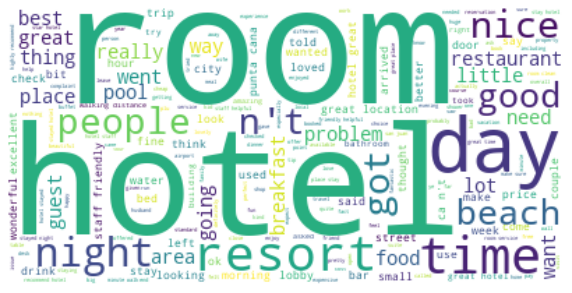

In [6]:
text = " ".join(txt for txt in trip_data.Review)

wordcloud = WordCloud(background_color="white").generate(text)

fig = plt.figure(1, figsize=(10,10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

จากการแสดงจำนวนคำที่พบในรีวิวด้วย WorrdCloud จะเห็นได้ว่าคำที่พบบ่อยจะเป็นคำว่า hotel, resort, room, day, time ซึ้งโดยส่วนใหญ่จะพบคำเหล่านี้อยู่ในช้อมูลของโรมแรมอยู่แล้ว จึงค่อยมีผลต่อการการเทรนโมเดล

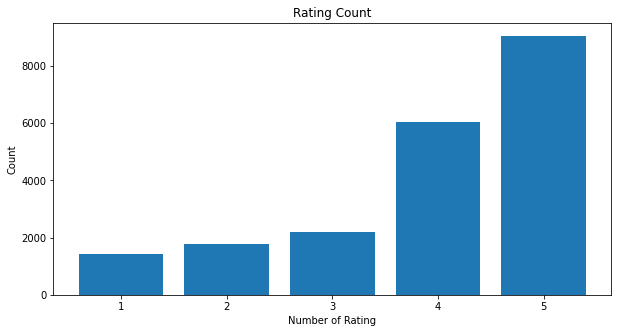

In [7]:
ranting = trip_data.Rating.value_counts()
fig = plt.figure(figsize=(10,5)) 
plt.bar(ranting.keys(), ranting.values)
plt.title('Rating Count')
plt.ylabel('Count')
plt.xlabel('Number of Rating')
plt.show()

ตรวจสอบจำนวนคะแนนที่ได้จะเห็นได้ว่าคะแนนส่วนใหญ่จะอยู่ระหว่าง 4 กับ 5 คะแนน

## **Preparing Data**

ขั้นตอนการเตรียมข้อมูลก่อนทำการนำข้อมูลเข้าไปเทรนจำเป็นอย่างมาก โดยที่ส่วนสำคัญนั้นคือการเปลี่ยนรูปแบบข้อมูลจากข้อความให้อยู่ในรูปแบบที่คอมพิวเตอร์สามารถอ่านได้ โดยมีขั้นตอนดังนี้

*  Clean Data ทำความสะอาดข้อมูลจากข้อความ โดยลบคำที่เป็น stop word ที่ไม่ตำเป็น และคำที่พบบ่อยจากการทำ wordclou ซึ่งไม่มีผลต่อการวิเคราะห์คะแนนรีวิว

*  Preprocessing Data  การเปลี่ยนข้อมูลที่อยู่ในรูปแบบข้อความให้อยู่ในรูปแบบของตัวเลข เพื่อทำให้คอมพิวเตอร์สามารถอ่านได้ โดยการตัดคำและทำให้คำอยู่ในรูปแบบของ vector

### Clean Data

In [8]:
import nltk

p_stemmer = PorterStemmer()
nltk.download('stopwords')
en_stop = set(stopwords.words('english') + ['hotel', 'resort', 'room', 'time', 'day'])


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [9]:
def clean_text(txt):
  # ทำความสะอาดข้อมูลที่เป็น Text
  
  text=txt.lower()
    
  for c in string.punctuation:
    txt = re.sub(r'\{}'.format(c),'',txt)
  
  txt = ' '.join(txt.split())
    
  txt=re.sub("(\.\s+)", ' ', txt)
  txt=re.sub("(\-\s+)", ' ', txt)
  txt=re.sub("(\:\s+)", ' ', txt) 
        
  txt=re.sub("(\s+.\s+)", ' ', txt)
  txt=re.sub("(\s+.\s+)", ' ', txt)

  txt = txt.split()

  txt = [w for w in txt if not w in en_stop] 

  txt = [p_stemmer.stem(i) for i in txt]

  txt = [i for i in txt if not i.isnumeric()]

  txt = ' '.join(txt)
  
  return txt

In [10]:
trip_data['Review'] = [clean_text(txt) for txt in trip_data.Review]
trip_data['Review']

0        nice expens park got good deal stay anniversar...
1        ok noth special charg diamond member hilton de...
2        nice room experi monaco seattl good nt levelpo...
3        uniqu great stay wonder monaco locat excel sho...
4        great stay great stay went seahawk game awesom...
                               ...                        
20486    best kept secret 3rd stay charm 5star ca nt be...
20487    great locat price view great quick place sight...
20488    ok look nice modern outsid desk staff nt parti...
20489    theft ruin vacat open sept guest week happi st...
20490    peopl talk ca nt believ excel rate nt ye patri...
Name: Review, Length: 20491, dtype: object

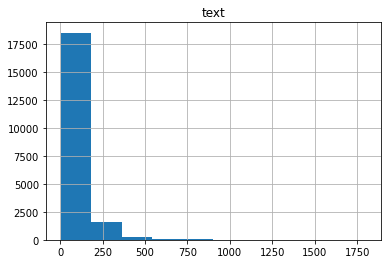

In [11]:
text_count = []
summary_count = []

for sent in trip_data['Review']:
    text_count.append(len(sent.split()))

graph_df= pd.DataFrame()
graph_df['text']=text_count

graph_df.hist(bins = 10)
plt.show()

In [12]:
cnt=0
for i in trip_data['Review']:
    if(len(i.split())<=500):
        cnt=cnt+1
print(cnt/len(trip_data['Review']))

0.9926309111317163


### Preprocessing Data

Split data

In [13]:
X = trip_data['Review']
le = LabelEncoder()
y = le.fit_transform(trip_data.Rating.values)

In [14]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=2475)

Tokenizer

In [15]:
from keras.preprocessing.text import Tokenizer
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)
X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)
review_word_index = tokenizer.word_index
len(review_word_index)

56865

In [16]:
size_of_vocabulary=len(tokenizer.word_index) + 1
print(size_of_vocabulary)

56866


In [17]:
from keras.preprocessing.sequence import pad_sequences
MAX_LEN = 500
X_train_pad_seq = pad_sequences(X_train_seq, maxlen=MAX_LEN, padding='post')
X_test_pad_seq = pad_sequences(X_test_seq, maxlen=MAX_LEN, padding='post')

## **Model**

นำข้อมูลที่ได้นำมาเทรนผ่านโมเดล convolutional neural network หรือ CNN โดยที่โมลเดล CNN นั้นเป็นอีกหนึ่งโมเดลที่เหมาะสำหรับใช้ในการทำนายข้อมูลที่อยู่ในรูปแบบของ Text ได้

### Word Embeddings

Pre-trained word embeddings โดยใช้ GloVe

In [18]:
embeddings_index = dict()
f = open('glove.6B.300d.txt')

for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs

f.close()
print('Loaded %s word vectors.' % len(embeddings_index))

Loaded 400000 word vectors.


In [19]:
embedding_matrix = np.zeros((size_of_vocabulary, 300))

for word, i in tokenizer.word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

### CNN Model

In [20]:
early_stopping = EarlyStopping(monitor='val_accuracy', verbose=1,patience=2)  
callback = [early_stopping]

In [46]:
X_train = np.array(X_train_pad_seq)
y_train = np.array(y_train)

model = Sequential()
model.add(Embedding(size_of_vocabulary, 300, weights=[embedding_matrix], input_length=500, trainable=False))
model.add(Conv1D(128, 3, activation='relu'))
model.add(GlobalMaxPooling1D())
model.add(Dense(100, activation='relu', kernel_regularizer=l2(1e-5), bias_regularizer=l2(1e-5)))
model.add(Dropout(0.5))
model.add(Dense(5, activation='softmax'))
model.compile(loss='sparse_categorical_crossentropy', optimizer=Adam(learning_rate=0.0001), metrics=['accuracy'])
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 500, 300)          17059800  
_________________________________________________________________
conv1d_4 (Conv1D)            (None, 498, 128)          115328    
_________________________________________________________________
global_max_pooling1d_4 (Glob (None, 128)               0         
_________________________________________________________________
dense_8 (Dense)              (None, 100)               12900     
_________________________________________________________________
dropout_4 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_9 (Dense)              (None, 5)                 505       
Total params: 17,188,533
Trainable params: 128,733
Non-trainable params: 17,059,800
____________________________________

In [47]:
history2 = model.fit(X_train, y_train, validation_split=0.2, epochs=20, batch_size=64, verbose=1, callbacks=callback)

Epoch 1/20
205/205 [==============================] - 4s 17ms/step - loss: 1.6339 - accuracy: 0.3348 - val_loss: 1.3305 - val_accuracy: 0.4556
Epoch 2/20
205/205 [==============================] - 3s 15ms/step - loss: 1.3669 - accuracy: 0.4381 - val_loss: 1.2779 - val_accuracy: 0.4718
Epoch 3/20
205/205 [==============================] - 3s 15ms/step - loss: 1.2876 - accuracy: 0.4554 - val_loss: 1.2226 - val_accuracy: 0.4712
Epoch 4/20
205/205 [==============================] - 3s 15ms/step - loss: 1.2265 - accuracy: 0.4791 - val_loss: 1.1798 - val_accuracy: 0.5005
Epoch 5/20
205/205 [==============================] - 3s 15ms/step - loss: 1.1667 - accuracy: 0.5092 - val_loss: 1.1385 - val_accuracy: 0.5185
Epoch 6/20
205/205 [==============================] - 3s 15ms/step - loss: 1.1124 - accuracy: 0.5319 - val_loss: 1.1021 - val_accuracy: 0.5276
Epoch 7/20
205/205 [==============================] - 3s 15ms/step - loss: 1.0625 - accuracy: 0.5552 - val_loss: 1.0716 - val_accuracy: 0.5416

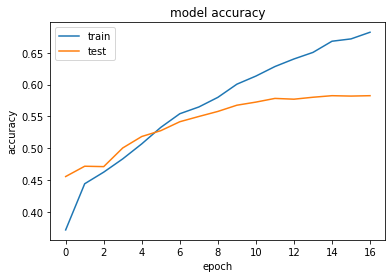

In [48]:
plt.plot(history2.history['accuracy'])
plt.plot(history2.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

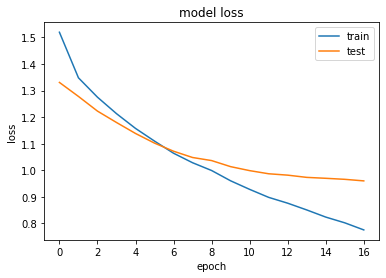

In [49]:
plt.plot(history2.history['loss'])
plt.plot(history2.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

## **Evaluation**

ประเมินผลการเทรนของโมเดลด้วย metrics ต่อไปนี้

*  Accuracy การประที่ง่ายที่สุดด้วยการประเมินผลว่าโมเดลทำนายถูกเป็นจำนวน %

*  Confusion matrix เพื่อแสดงการรวมกันระหว่างผลจริงกับการทำนาย

In [50]:
pred_train = np.argmax(model.predict(X_train_pad_seq), axis=-1)
pred_test = np.argmax(model.predict(X_test_pad_seq), axis=-1)
print('Train Accuracy: {}'.format(accuracy_score(pred_train, y_train)))
print('Test Accuracy: {}'.format(accuracy_score(pred_test, y_test)))

Train Accuracy: 0.7287701317715959
Test Accuracy: 0.5642839717004148


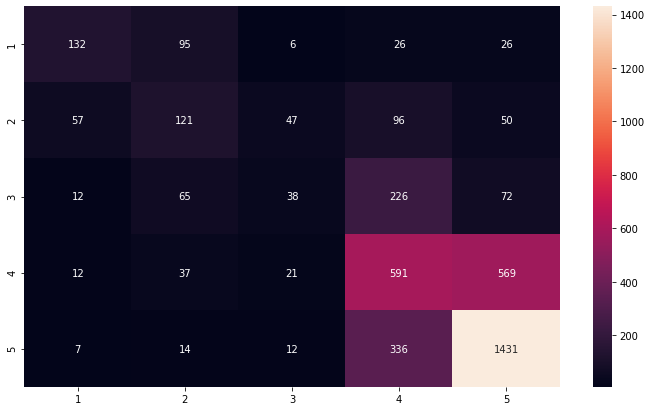

In [51]:
cf = confusion_matrix(y_test, pred_test)

cm = pd.DataFrame(cf, index = [i for i in ['1', '2', '3', '4', '5']], columns = [i for i in ['1', '2', '3', '4', '5']])

plt.figure(figsize = (12,7))
sns.heatmap(cm, annot=True, fmt="d")
plt.show()

## **Conclusion**

จากการสร้างโมเดลทำนายคะแนนรีวิวจากข้อความการรีวิวจากลูกค้าที่เข้าใช้บริการเว็บไซต์จองโรงแรม Tripadvisor โดยการใช้โมเดล convolutional neural network ในการทำนายข้อความรีวิว จะเห็นได้ว่าโมเดลที่ทำนายออกมานั้นมีประสิทธิภาพที่ไม่ค่อยดีเท่าที่ควร Accuracy ที่ได้นั้นได้อยู่เพียงแค่ประมาณ 56.4 % และในส่วนของการประเมินผลผ่านการใช้ confusion matrix จะเห็นได้ว่าการทำนายคะแนนจะไม่ตรงกับข้อมูลจริงอยู่มาก สาเหตุอาจเป็นเพราะมาจากว่าการทำนายคะแนนรีวิวจากข้อความการรีวิวอาจจะไม่สามารถบอกคะแนนของการรีวิวได้ดีมากนัก จึงจำเป็นต้องใช้ข้อมูลจาก fearture อื่นๆที่เหมาะสมมากกว่าในการทำนายคะแนนรีวิวมากนี้